In [1]:
%load_ext autoreload
%autoreload 2

# Représentation du cumul annuel de précipitation 2025 en France métropolitaine

## Présentation du projet

On dispose du cumul de précipitations observées sur la France et ses environs pour l'année 2025.

**L'objectif de ce mini-projet est de mettre en évidence la méthode d'interpolation la plus adaptée pour la représentation de ce jeu de données sur la France métropolitaine**.

On considère pour cela les méthodes d'interpolation implémentées en python lors des séances pratiques :
+ `interp_lin` : interpolation linéaire à partir d'une triangulation.
+ `interp_spl` : interpolation par splines (plusieurs coefficients de lissage possibles).
+ `interp_inv` : interpolation par inverse des distances.
+ `interp_krg` : interpolation par krigeage ; **le choix du variogramme** devra être étudié et justifié (cubique, linéaire, gaussien ou autre) ; on justifiera également la distance maximale sur laquelle ajuster le variogramme analytique à partir du variogramme expérimental. Les **cartes d'incertitude** du krigeage seront utilisées lors de l'analyse des résultats.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
import lib_gs as lib

## Présentation des données

### Mesures de précipitation du réseau de stations sol

Les données sont contenues dans le fichier `FR_precipitation_2025.txt`, et sont organisées sous la forme suivante :

| $E$ (m) | $N$ (m) | $TP$(mm) |
|---------|---------|-----------|

Où $E,N$ désignent les coordonnées Easting et Northing en RGF93 / Lambert 93 ; $TP$ est la quantité de précipitation en mm sur l'année 2025.

Le chargement de ces données peut se faire de la manière suivante :

In [3]:
obs =np.loadtxt('FR_precipitation_2025.txt')
E = obs[:,0:1]/1e3 # km
N = obs[:,1:2]/1e3 # km
TP = obs[:,2:3]
print(min(TP), max(TP))

[483.7] [1794.8]


### Contour de la France métropolitaine

Pour agrémenter vos figures, un contour de la France métropolitaine est mis à disposition dans le fichier `FR_contour.txt` ; ce contour représent les ces de la France contineltale ainsi que celui des îles proches. Il se présente comme un ennsemble de coordonnées en projection, séparées par des `NaN` pour différencier les différents polygones. Les données sont organisées sous la forme suivante :

| $E$ (m) | $N$ (m) |
|---------|---------|

Le chargement de ces données peut se faire de la manière suivante :

In [4]:
FR_contour =np.loadtxt('FR_contour.txt')
Ec = FR_contour[:,0:1]/1e3
Nc = FR_contour[:,1:2]/1e3

### Visualisation des données

Le fichier `ncl.rgb` contient une carte de couleur proposée par le NCL (NCAR Command Language), un langage de programmation développé par le NCAR pour la visualisation et l'analyse de données scientifiques, notamment en météorologie et climatologie. On va l'utiliser pour la visualisation de nos données.

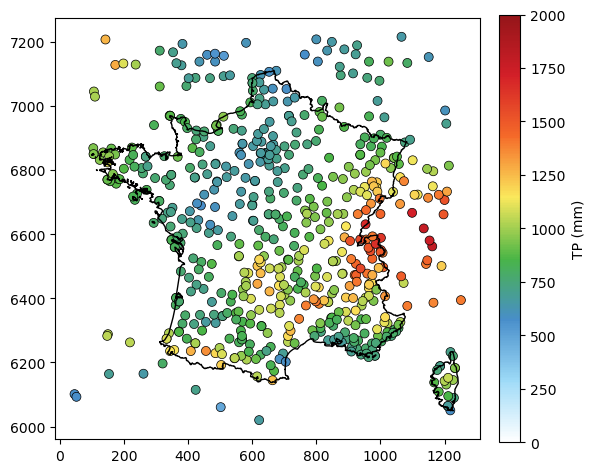

In [5]:
fig = plt.figure(figsize=(6,6))
# chargement de la carte de couleur et conversion au format matplotlib
NCL = col.ListedColormap(np.loadtxt('ncl.rgb')/255)
# tracé des vitesses observées, sous forme de cercles de taille 42, avec un contour noir de taille 0.5
lib.plot_patch(E,N,TP,fig=fig,minmax = [0,2000],marker='o',s=42,cmap=NCL,lw=0.5, ec='k',cb=True,zlabel='TP (mm)')
# tracé des contours
plt.plot(Ec,Nc,'k',linewidth=1)
plt.grid();

## 1. Interpolation ponctuelle
Ci-dessous les coordonnées approchées de 4 villes.

| Ville            | $x$ (km) | $y$ (km)|
|------------------|----------|---------|
| Brest            | 145.7    | 6835.2  |
| Champs-sur-Marne | 669.7    | 6860.2  |
| Toulouse         | 577.3    | 6273.7  |
| Forcalquier      | 923.1    | 6322.7  |

1. Déterminer à l'aide des interpolateurs disponibles le cumul annuel de précipitation pour ces 4 villes. Pour le krigeage, indiquer également l'incertitude associée
2. Commenter ces résultats

## 2. Carte de précipitation

1. Visualiser les carte de cumul de précipitation issue des différentes méthodes d'interpolation.
2. Commenter ces résultats

Quelques caractéristiques de la carte demandée :
+ Interpolation :
    + On interpolera les données sur une grille de pas de 30 km en $x$ et $y$.
    + Les cumuls de précipitation seront représentés *classiquement* sous forme de couleurs.
+ On affichera le contour de la France sur ces cartes.
+ On limitera l'interpolation aux points à l'intérieur du contour et à ceux situés à moins de 15 km de ce contours. Pour cela, on peut utiliser la librairie [`matplotlib.path`](https://matplotlib.org/stable/api/path_api.html) et la méthode `contains_points` :

In [6]:
import matplotlib.path as pth

def is_in(poly, points):
    # poly : ensemble de polygines
    # points : points np.array
    if poly.contains_points( points ):
        print("Le point appartient au contour")
    else:
        print("Le point n'appartient pas au contour")

poly = pth.Path(FR_contour)
# Point au centre de la Corse
is_in(poly, np.array([[1225533,6157602]]))
# Point dans la Méditerranée
is_in(poly, np.array([[1097842,6153974]]))

Le point appartient au contour
Le point n'appartient pas au contour


## 3. Détermination de la méthode d'interpolation la plus adaptée

On veut mettre en évidence la méthode d'interpolation la plus adaptée à notre jeu de données. Celle-ci va être déterminée par **validation croisée**.

1. Implémenter une méthode de validation croisée pour l'évaluation des différents interpolateurs. Pour rappel, la validation croisée se déroule en 4 étapes :
    1. On extrait un point du jeu de données, pour obtenir un jeu de données réduit ;
    2. On calcule une valeur interpolée en ce point à partir du jeu de données réduit ;
    3. On compare la valeur interpolée à la valeur observée ;
    4. On itère (sur 50 à 200 points selon la rapidité des méthodes que vous avez implémentées).
2. Quantifier la qualité de chaque méthode en calculant des statistiques suivantes : **erreur moyenne**, **écart-type de l'erreur**, **erreur moyenne quadratique**, **indice de Willmot**.
3. Pour chaque méthode, représenter le diagramme de corrélation ainsi que l'histogramme des erreurs
4. Conclure quant à la méthode d'interpolation la plus adaptée à ces données.
    
Quelques contraintes à respecter pour la validation croisée :
+ L'échantillon de points à comparer doit être rigoureusement identique pour toutes les méthodes évaluées ;
+ Un point ne peut-être extrait qu'une seule fois.


Quelques fonctions qui pourront être utiles à cette étape de validation croisée : [`np.random.randint`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html), [`np.nanmean`](https://numpy.org/doc/stable/reference/generated/numpy.nanmean.html), [`np.nanstd`](https://numpy.org/doc/stable/reference/generated/numpy.nanstd.html), [`np.isnan`](https://numpy.org/doc/stable/reference/generated/numpy.isnan.html).

## Rendus
Sont attendus à l'issue de ce mini-projet :
+ Un rapport, au format pdf, contenant les valeurs chiffrées demandées, les cartes produites et vos commentaires.
+ Les codes pythons, commentés et exécutables.

Le tout doit être regroupé dans une unique archive nommée `NOM1_NOM2.???` où `NOM1` et `NOM2` sont les noms de famille des membres du binôme.